In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TraPredModel import TraPredModel

In [2]:
import torch.utils
import torch.utils.data


lookback = 20
dir = '../data/PandasData/Sampled/'
ds = MyDataset(lookback=lookback)
train_batch_size = 4
test_batch_size = 16

def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.dropna(inplace=True, how='any')
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    if f_per_sec < target_freq:
        raise ValueError('The frequency of the data is lower than the target frequency')
    elif int(f_per_sec) == target_freq:
        pass
    else:
        resample_ratio = int(f_per_sec/target_freq)
        df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget']:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)


In [3]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data()

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)


feature_dim = ds.feature_dim
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/notebook/../src/MyDataset.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'start_station_X', 'start_station_Y', 'end_station_X',
       'end_station_Y', 'distance_from_start_station_X',
       'distance_from_start_station_Y', 'distance_from_end_station_X',
       'distance_from_end_station_Y', 'facing_start_station',
       'facing_end_station', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'AGV_name',
       'looking_at_closest_station', 'rolling_avg'],
      dtype='object') 
feature_dim : 32


In [4]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([4, 20, 32]) torch.Size([4, 20, 32])
20562 2285


In [31]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class GatedLinearUnit(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Linear(input_size, input_size)
        self.gate = nn.Linear(input_size, input_size)
    
    def forward(self, x):
        return torch.sigmoid(self.gate(x)) * self.fc(x)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, num_heads=8, dropout=0.1, device='cpu'):
        super().__init__()
        self.device = device
        
        # Transformer Block
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # Gated Linear Unit Networks
        self.glu = GatedLinearUnit(hidden_size)

        # Fully connected output network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x, mask=None):
        # Initial transformation
        x = self.fc1(x)

        # Applying Transformer Block
        attn_output, _ = self.multihead_attn(x, x, x, key_padding_mask=mask)
        x = x + self.dropout(attn_output)
        x = self.layer_norm(x)

        # Gated Linear Unit
        x = self.glu(x)
        
        # Final output layer
        x = self.fc2(self.activation(x))
        return x

class TraPredModel(nn.Module):
    def __init__(self, input_size=None, lookback=None, layers=[256, 256], hidden_size=64, bidirectional=True, device='cpu'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = lookback
        self.device = device
        
        # TFT
        self.TFT = TemporalFusionTransformer(input_size=feature_dim, output_size=feature_dim, hidden_size=64, num_heads=8, dropout=0.1, device=device)

        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=lookback, batch_first=True, bidirectional=bidirectional, dropout=0.1)

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=lookback, batch_first=True, bidirectional=bidirectional, dropout=0.1)

        self.bi = 2 if bidirectional else 1
        neuron_num = hidden_size * self.bi

        mlp_layers = []
        in_features = neuron_num
        layers.append(input_size)
        for out_features in layers:
            mlp_layers.append(nn.Linear(in_features, out_features))
            mlp_layers.append(nn.ReLU())  # Adding ReLU activation function after each Linear layer
            mlp_layers.append(nn.Dropout(0.2))  # Adding dropout layer
            in_features = out_features  # Update in_features for the next layer
        
        mlp_layers.pop()  # Remove the last ReLU added in the loop
        mlp_layers.pop()  # Remove the last Dropout added in the loop
        
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x, future_steps=5):
        
        # Encoding
        x = self.TFT(x)
        
        encoder_out, (h_n, c_n) = self.encoder_lstm(x)

        # Prepare the decoder input (initially zero)
        decoder_input = torch.zeros(x.size(0), 1, x.size(2)).to(self.device)
        outputs = []

        # Decoding for the required number of future steps
        for _ in range(future_steps):
            decoder_out, (h_n, c_n) = self.decoder_lstm(decoder_input, (h_n, c_n))
            output = self.mlp(decoder_out[:, -1, :])
            outputs.append(output.unsqueeze(1))
            decoder_input = output.unsqueeze(1)  # Feeding the output as the next input

        return torch.cat(outputs, dim=1)
    

In [23]:

    
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using {device}")
# model = TemporalFusionTransformer(input_size=feature_dim, output_size=feature_dim, hidden_size=64, num_heads=8, dropout=0.1, device=device)

# optimizer = optim.AdamW(model.parameters(), lr=1e-7)
# loss_fn = nn.MSELoss()

# model.to(device)


# n_epochs = 10
# eval_step = 500
# future_steps = 20

# # model = TraPredModel(input_size=numeric_df.shape[1], lookback=lookback)

# save_every = 10000
# train_all = len(train)

# loss_all = []

# now = datetime.now()
# folder_name = now.strftime("%b%d_%H-%M-%S")
# os.makedirs(f'../model/{folder_name}', exist_ok=True)


# for epoch in range(n_epochs):
#     model.train()
#     for step, (X_batch, y_batch) in tqdm(enumerate(train), total = train_all):
#         X_batch = X_batch.float().to(device)
#         y_batch = y_batch.float().to(device)
#         optimizer.zero_grad()
        
#         y_pred = model(X_batch)
#         loss = torch.mean(loss_fn(y_pred, y_batch[:, :1, :].squeeze(1)))
        
#         if torch.isnan(loss):
#             print("Loss is NaN")
#             continue
#         loss_all.append(loss.item())
#         loss.backward()
#         # Apply gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
        
#         # Validation
#         if (epoch * train_all + step + 1) % save_every == 0:
#             print(f"Saving model at epoch {epoch+1}, step {step+1}")

#             torch.save(model.state_dict(), f"../model/{folder_name}/model_{epoch+1}_{step+1}.pt")
        
#         if (epoch * train_all + step + 1) % eval_step == 0:
#             print(f"Start testing")
#             with torch.no_grad():
#                 model.eval()
#                 all_test = len(test)
#                 test_rmse_all = []
#                 for X_test_batch, y_test_batch in tqdm(test):

#                     X_test_batch = X_test_batch.float().to(device)
#                     y_test_batch = y_test_batch.float().to(device)
#                     y_pred = model(X_test_batch)
#                     test_rmse = torch.mean(loss_fn(y_pred, y_test_batch[:, :1, :]))
#                     test_rmse = torch.sqrt(test_rmse)
#                     if not torch.isnan(test_rmse):
#                         test_rmse_all.append(test_rmse.item())

#                 print("Epoch %d: test RMSE %.4f" % (epoch+1, sum(test_rmse_all)/all_test))
            
#             model.train()
        




Using cuda


  0%|          | 0/20562 [00:00<?, ?it/s]

/home/shaoze/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 32])) that is different to the input size (torch.Size([4, 20, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (20) must match the size of tensor b (4) at non-singleton dimension 1

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

model = TraPredModel(input_size=feature_dim, lookback=lookback, \
    hidden_size=128, bidirectional=True, device=device)
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
loss_fn = nn.MSELoss()

model.to(device)


Using cuda


TraPredModel(
  (TFT): TemporalFusionTransformer(
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (glu): GatedLinearUnit(
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (gate): Linear(in_features=64, out_features=64, bias=True)
    )
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (activation): ReLU()
  )
  (encoder_lstm): LSTM(32, 128, num_layers=20, batch_first=True, dropout=0.1, bidirectional=True)
  (decoder_lstm): LSTM(32, 128, num_layers=20, batch_first=True, dropout=0.1, bidirectional=True)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_featur

In [33]:

n_epochs = 10
eval_step = 1000
future_steps = 20

# model = TraPredModel(input_size=numeric_df.shape[1], lookback=lookback)

save_every = 10000
train_all = len(train)

loss_all = []

now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
os.makedirs(f'../model/{folder_name}', exist_ok=True)


for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total = train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        optimizer.zero_grad()
        
        if X_batch.shape[0] != model.batch_size:
            continue
        y_pred = model(X_batch, future_steps=future_steps)
        loss = torch.mean(loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2].squeeze(1)))
        
        if torch.isnan(loss):
            print("Loss is NaN")
            continue
        loss_all.append(loss.item())
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        if (epoch * train_all + step + 1) % save_every == 0:
            print(f"Saving model at epoch {epoch+1}, step {step+1}")

            torch.save(model.state_dict(), f"../model/{folder_name}/model_{epoch+1}_{step+1}.pt")
        
        if (epoch * train_all + step + 1) % eval_step == 0:
            print(f"Start testing")
            with torch.no_grad():
                model.eval()
                all_test = len(test)
                test_rmse_all = []
                for X_test_batch, y_test_batch in tqdm(test):
                    if X_test_batch.shape[0] != model.batch_size:
                        continue
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    y_pred = model(X_test_batch, future_steps=future_steps)
                    test_rmse = torch.mean(loss_fn(y_pred[:, :future_steps, :2], y_test_batch[:, :future_steps, :2]))
                    test_rmse = torch.sqrt(test_rmse)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())

                print("Epoch %d: test RMSE %.4f" % (epoch+1, sum(test_rmse_all)/all_test))
            
            model.train()
        



  0%|          | 0/20562 [00:00<?, ?it/s]

Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.4667
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.4461
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.4167
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.3530
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2911
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2843
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2837
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2835
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2840


KeyboardInterrupt: 

In [34]:
y_batch[3, :, :2]

tensor([[0.5127, 0.5341],
        [0.5126, 0.5259],
        [0.5125, 0.5180],
        [0.5125, 0.5137],
        [0.5125, 0.5128],
        [0.5125, 0.5128],
        [0.5125, 0.5128],
        [0.5125, 0.5128],
        [0.5125, 0.5128],
        [0.5125, 0.5128],
        [0.5125, 0.5128],
        [0.5124, 0.5124],
        [0.5122, 0.5103],
        [0.5120, 0.5074],
        [0.5118, 0.5030],
        [0.5118, 0.4967],
        [0.5119, 0.4895],
        [0.5119, 0.4823],
        [0.5120, 0.4755],
        [0.5120, 0.4693]], device='cuda:0')

In [35]:
y_pred[3, :, :2]

tensor([[0.4858, 0.4016],
        [0.5186, 0.3678],
        [0.4675, 0.4514],
        [0.4267, 0.3913],
        [0.4543, 0.3850],
        [0.4278, 0.3440],
        [0.4942, 0.3227],
        [0.3915, 0.3096],
        [0.4038, 0.2940],
        [0.4094, 0.3385],
        [0.4807, 0.3725],
        [0.4246, 0.3643],
        [0.4803, 0.3855],
        [0.5315, 0.4708],
        [0.5249, 0.4014],
        [0.4629, 0.4613],
        [0.4920, 0.5270],
        [0.5286, 0.4057],
        [0.4967, 0.4431],
        [0.4789, 0.3480]], device='cuda:0', grad_fn=<SliceBackward0>)

<Axes: title={'center': 'Loss'}>

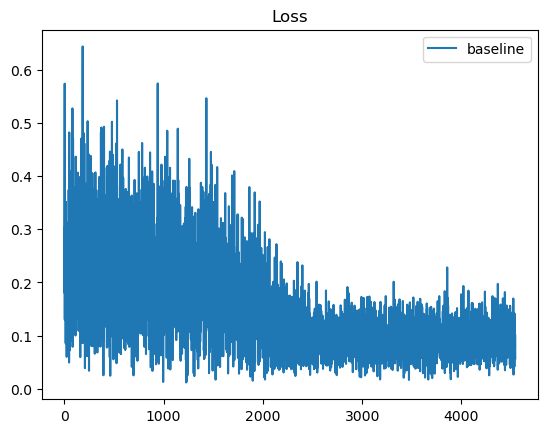

In [36]:
df = pd.DataFrame({'baseline': loss_all}) #, 'state': loss_state
df.plot(title='Loss')

In [ ]:
loss_np = np.sqrt(np.array(loss_all))
np.save('../model/loss_baseline.npy', loss_np)